## Results first
#### Because why not. 

**Standard architecture**: 
2-gram, embed 100, vocab 10000, tokenization scheme (same as lab),   
learning_rate = 0.005, num_epochs = 4. 

| Hyperparameters                        | val_accuracy (%) |
|----------------------------------------|------------------|
| Standard                               | 83.16            |
| 1-gram                                 | 86.80            |
| 3-gram                                 | 77.48            |
| 4-gram                                 | 71.0             |
| 1-gram + tok_scheme: remove stop words | 88.48            |
| vocab: 30,000                          | 85.48            |
| vocab: 50,000                          | 85.82            |
| embedding: 300                         | 83.2             |
| embedding: 500                         | 83.48            |
| 1-gram, embed 300, vocab 50k           | 88.02            |
| 1-gram, embed 500, vocab 50k           | 87.90            |
| 2-gram, embed 300, vocab 50k           | 85.28            |
| 2-gram, embed 500, vocab 50k           | 85.52            |
| 3-gram, embed 300, vocab 50k           | 81.21            |
| 3-gram, embed 500, vocab 50k           | 81.36            |

### Now the code. 

### One-time loading of data from text files

In [1]:
import os
import random
import spacy
import string
from os import listdir
import pickle as pkl
import torch
import matplotlib
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
'''
Data loading code inspired from: https://machinelearningmastery.com/prepare-movie-review-data-sentiment-analysis/
'''

# load doc into memory
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text
 
# load all docs in a directory
def process_docs(directory, data):
    # walk through all files in the folder
    i = 0
    for filename in listdir(directory):
        # skip files that do not have the right extension
        if not filename.endswith(".txt"):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load document
        data.append(load_doc(path))
        i += 1
    print("Loaded {} files from {}".format(i, directory))
    return i

In [ ]:
TRAIN_DATA_DIR = '/Users/vrajiv/Desktop/NLP Class/lab3/aclImdb/train/'
TEST_DATA_DIR = '/Users/vrajiv/Desktop/NLP Class/lab3/aclImdb/test/'
TRAIN_VAL_SPLIT = 20000
SEED = 1

full_train_data = []

num_pos = process_docs(TRAIN_DATA_DIR + 'pos', full_train_data)
num_neg = process_docs(TRAIN_DATA_DIR + 'neg', full_train_data)

full_train_labels = [0] * (num_pos + num_neg)
for i in range(num_pos):
    full_train_labels[i] = 1

# randomly shuffle data 
# do it for labels as well, so they get shuffled the same way
random.Random(SEED).shuffle(full_train_data)
random.Random(SEED).shuffle(full_train_labels)

# Split train data into actual train and validation sets
train_data = full_train_data[:TRAIN_VAL_SPLIT]
val_data = full_train_data[TRAIN_VAL_SPLIT:]

# Same for labels
train_labels = full_train_labels[:TRAIN_VAL_SPLIT]
val_labels = full_train_labels[TRAIN_VAL_SPLIT:]

print("Total length of train data: {}".format(len(train_data)))
print("Total length of validation data: {}".format(len(val_data)))


###
### TEST DATA 
###

test_data = []

num_pos = process_docs(TEST_DATA_DIR + 'pos', test_data)
num_neg = process_docs(TEST_DATA_DIR + 'neg', test_data)

test_labels = [0] * (num_pos + num_neg)
for i in range(num_pos):
    test_labels[i] = 1

# randomly shuffle data
random.Random(SEED).shuffle(test_data)
random.Random(SEED).shuffle(test_labels)
print("Total length of test data: {}".format(len(test_data)))

In [ ]:
# verify that labels (sentiment) and reviews match in train data. 
def verify_match(data, labels):
    rand_seed = random.randint(1, 101)
    print(random.Random(rand_seed).choice(data))
    print(random.Random(rand_seed).choice(labels))

In [ ]:
verify_match(train_data, train_labels)

In [ ]:
verify_match(val_data, val_labels)

### Storing train/val/test as lists -- pickle

In [ ]:
with open('movie_review_train_data.p', 'wb') as f:
    pkl.dump(train_data, f)
    
with open('movie_review_train_labels.p', 'wb') as f:
    pkl.dump(train_labels, f)
    
with open('movie_review_val_data.p', 'wb') as f:
    pkl.dump(val_data, f)
    
with open('movie_review_val_labels.p', 'wb') as f:
    pkl.dump(val_labels, f)
    
with open('movie_review_test_data.p', 'wb') as f:
    pkl.dump(test_data, f)
    
with open('movie_review_test_labels.p', 'wb') as f:
    pkl.dump(test_labels, f)

### Fetching train/val/test data -- pickle

In [2]:
train_data = pkl.load(open("movie_review_train_data.p", "rb"))
train_labels = pkl.load(open("movie_review_train_labels.p", "rb"))
val_data = pkl.load(open("movie_review_val_data.p", "rb"))
val_labels = pkl.load(open("movie_review_val_labels.p", "rb"))
test_data = pkl.load(open("movie_review_test_data.p", "rb"))
test_labels = pkl.load(open("movie_review_test_labels.p", "rb"))

In [4]:
random.choice(train_data)

"This definitely is NOT the intellectual film with profound mission, so I really don't think there is too much not to understand to in case you aren't Czech.<br /><br />It's just a comedy. The humor is simple, pretty funny and sometimes, maybe, little morbid. Some actors and characters are very similar to Samotári (2000) (Jirí Machácek, Ivan Trojan, Vladimír Dlouhý) so the authors are. But it doesn't matter, the genre is really different and these two films shouldn't be compared in this way. Jedna ruka netleská won't try to give you a lesson, it will try to make you laugh and there is some chance it will succeed.<br /><br />Not bad film, not the ingenious one, but I enjoyed it. Some scenes are truly worth seeing."

### Some things I notice from examining training set data

I see ... html tags, hex codes. On average, good grammar so that's cool.   
Filter out html tags + hex codes? Not sure.  
Also not sure if I want to filter out exclamation marks/question marks. That might be very useful for expressing a sentiment. 

### Tokenization (standard scheme from lab + 2nd scheme: remove stop words)

In [5]:
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation as well as stop words (for 2nd tokenization scheme
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations and token.text not in STOP_WORDS)]

# Example
tokens = tokenize(u'Apple is looking at buying U.K. startup for $1 billion')
print (tokens)

['apple', 'looking', 'buying', 'u.k.', 'startup', '1', 'billion']


In [6]:
def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

# # val set tokens
# print ("Tokenizing val data")
# val_data_tokens, _ = tokenize_dataset(val_data)
# pkl.dump(val_data_tokens, open("movie_review_val_data_tokens.p", "wb"))

# # test set tokens
# print ("Tokenizing test data")
# test_data_tokens, _ = tokenize_dataset(test_data)
# pkl.dump(test_data_tokens, open("movie_review_test_data_tokens.p", "wb"))

# # train set tokens
# print ("Tokenizing train data")
# train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
# pkl.dump(train_data_tokens, open("movie_review_train_data_tokens.p", "wb"))
# pkl.dump(all_train_tokens, open("movie_review_all_train_tokens.p", "wb"))

###
### REMOVING STOP WORDS
###

# # # val set tokens
# print ("Tokenizing val data")
# val_data_tokens, _ = tokenize_dataset(val_data)
# pkl.dump(val_data_tokens, open("movie_review_val_data_tokens_stop_words.p", "wb"))

# # # test set tokens
# print ("Tokenizing test data")
# test_data_tokens, _ = tokenize_dataset(test_data)
# pkl.dump(test_data_tokens, open("movie_review_test_data_tokens_stop_words.p", "wb"))

# # # train set tokens
# print ("Tokenizing train data")
# train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
# pkl.dump(train_data_tokens, open("movie_review_train_data_tokens_stop_words.p", "wb"))
# pkl.dump(all_train_tokens, open("movie_review_all_train_tokens_stop_words.p", "wb"))

Tokenizing val data
Tokenizing test data
Tokenizing train data


### Loading tokenized data

In [7]:
# load tokenized train, val and test datasets
# train_data_tokens = pkl.load(open("movie_review_train_data_tokens.p", "rb"))
# all_train_tokens = pkl.load(open("movie_review_all_train_tokens.p", "rb"))
# val_data_tokens = pkl.load(open("movie_review_val_data_tokens.p", "rb"))
# test_data_tokens = pkl.load(open("movie_review_test_data_tokens.p", "rb"))

### STOP WORDS -- scheme
train_data_tokens = pkl.load(open("movie_review_train_data_tokens_stop_words.p", "rb"))
all_train_tokens = pkl.load(open("movie_review_all_train_tokens_stop_words.p", "rb"))
val_data_tokens = pkl.load(open("movie_review_val_data_tokens_stop_words.p", "rb"))
test_data_tokens = pkl.load(open("movie_review_test_data_tokens_stop_words.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 2519291


### Build vocabulary from most common tokens

In [8]:
from collections import Counter
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

'''
Inspired from: http://locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/
'''
def generate_bag_ngrams(n, tokens):
    return zip(*[tokens[i:] for i in range(n)])

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(VOCAB_SIZE))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

### "One-hot encoding"
#### Represent each movie review as a vector of indices in our vocabulary

In [9]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data 

### Defining PyTorch Data Loader

In [10]:
MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class MovieReviewDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of movie review tokens 
        @param target_list: list of movie review targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def moviereview_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

### Defining Bag-of-Ngrams model in PyTorch

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # Apply the linear function to get our logit (real numbers)
        logit = self.linear(out.float())
        
        return logit

In [29]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
#         predicted = torch.tensor([1 if x >= 0.5 else 0 for x in outputs[:, 1]]      )
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def train_model(model,
              lr = 0.005, 
              num_epochs = 4, 
              criterion = nn.CrossEntropyLoss()):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # wd: linear
    losses = []
    xs = 0
    val_accs = []
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            losses.append(loss)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                xs = xs + 100
                val_accs.append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    return losses, xs, val_accs

In [ ]:
all_bigrams = list(generate_bag_ngrams(2, all_train_tokens))
all_unigrams = list(generate_bag_ngrams(1, all_train_tokens))
combined_one_two = all_bigrams + all_unigrams

In [ ]:
print(len(combined_one_two[5000000]))

In [ ]:
count = 0
for i in range(len(id2token)):
    if len(id2token[i]) == 2:
        count += 1
print("Length of idtoken is {}".format(len(id2token)))
print("Number of 1-gram tokens is {}".format(len(id2token) - count))
print("Number of 2-gram tokens is {}".format(count))

In [ ]:
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]
print(random_token)

## Full model run in one script (for quick hyperparameter tuning)

In [26]:
VOCAB_SIZE = 50000
NGRAM_SIZE = 2
EMBED_DIM = 300
LEARNING_RATE = 0.005
NUM_EPOCHS = 4

# Building the vocabulary
# UNCOMMENT FOR ORIGINAL tokenization scheme
token2id, id2token = build_vocab(generate_bag_ngrams(NGRAM_SIZE, all_train_tokens))
## TRYING MIXTURE of 1-grams and 2-grams
# token2id, id2token = build_vocab(combined_one_two)

# Lets check the dictionary by loading random token from it
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

# UNCOMMENT FOR ORIGINAL tokenization scheme
ngram_train_data_tokens = [list(generate_bag_ngrams(NGRAM_SIZE, review)) for review in train_data_tokens]
ngram_val_data_tokens = [list(generate_bag_ngrams(NGRAM_SIZE, review)) for review in val_data_tokens]
ngram_test_data_tokens = [list(generate_bag_ngrams(NGRAM_SIZE, review)) for review in test_data_tokens]

# ngram_train_data_tokens = [list(generate_bag_ngrams(1, review)) + list(generate_bag_ngrams(2, review)) for review in train_data_tokens]
# ngram_val_data_tokens = [list(generate_bag_ngrams(1, review)) + list(generate_bag_ngrams(2, review)) for review in val_data_tokens]
# ngram_test_data_tokens = [list(generate_bag_ngrams(1, review)) + list(generate_bag_ngrams(2, review)) for review in test_data_tokens]

train_data_indices = token2index_dataset(ngram_train_data_tokens)
val_data_indices = token2index_dataset(ngram_val_data_tokens)
test_data_indices = token2index_dataset(ngram_test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

BATCH_SIZE = 32
train_dataset = MovieReviewDataset(train_data_indices, train_labels)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=moviereview_collate_func,
                                           shuffle=True)

val_dataset = MovieReviewDataset(val_data_indices, val_labels)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=moviereview_collate_func,
                                           shuffle=True)

test_dataset = MovieReviewDataset(test_data_indices, test_labels)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=moviereview_collate_func,
                                           shuffle=False)

for i, (data, lengths, labels) in enumerate(train_loader):
    print (data)
    print(lengths)
    print (labels)
    break

Token id 14111 ; token ('initial', 'release')
Token ('initial', 'release'); token id 14111
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
tensor([[    1,     1,     1,  ...,     0,     0,     0],
        [    1,     1,   147,  ...,     0,     0,     0],
        [ 6092,     1,     1,  ...,     0,     0,     0],
        ...,
        [41895,     1,     1,  ...,     0,     0,     0],
        [ 9207,  8558,     1,  ...,     0,     0,     0],
        [    1, 38581, 30117,  ...,     0,     0,     0]])
tensor([139,  56,  90,  75, 200, 200, 103, 200, 200, 150, 200, 103, 149,  26,
         65, 116, 121,  17, 104, 140, 129,  65, 146,  95, 120, 200, 200,  44,
         72,  23,  79, 107])
tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 0])


In [27]:
model = BagOfWords(len(id2token), EMBED_DIM)

losses, xs, val_accs = train_model(model,
          lr = LEARNING_RATE, 
          num_epochs = NUM_EPOCHS, 
          criterion = nn.CrossEntropyLoss())

Epoch: [1/4], Step: [101/625], Validation Acc: 55.44
Epoch: [1/4], Step: [201/625], Validation Acc: 69.24
Epoch: [1/4], Step: [301/625], Validation Acc: 80.48
Epoch: [1/4], Step: [401/625], Validation Acc: 78.68
Epoch: [1/4], Step: [501/625], Validation Acc: 79.26
Epoch: [1/4], Step: [601/625], Validation Acc: 85.16
Epoch: [2/4], Step: [101/625], Validation Acc: 85.1
Epoch: [2/4], Step: [201/625], Validation Acc: 84.76
Epoch: [2/4], Step: [301/625], Validation Acc: 83.02
Epoch: [2/4], Step: [401/625], Validation Acc: 83.04
Epoch: [2/4], Step: [501/625], Validation Acc: 84.1
Epoch: [2/4], Step: [601/625], Validation Acc: 83.76
Epoch: [3/4], Step: [101/625], Validation Acc: 84.2
Epoch: [3/4], Step: [201/625], Validation Acc: 83.56
Epoch: [3/4], Step: [301/625], Validation Acc: 84.18
Epoch: [3/4], Step: [401/625], Validation Acc: 83.78
Epoch: [3/4], Step: [501/625], Validation Acc: 83.7
Epoch: [3/4], Step: [601/625], Validation Acc: 83.76


KeyboardInterrupt: 

Text(0,0.5,'Val Acc')

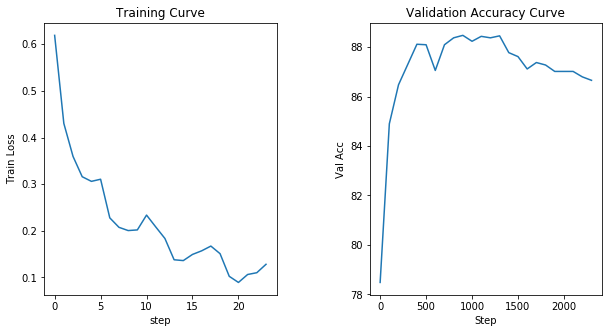

In [30]:
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

loss_avg_vals = []
for i in range(0, len(losses)-100, 100):
    s = 0
    avg = 0
    for j in range(i, i+100):
        s += losses[j]
    avg = s/100.0
    loss_avg_vals.append(avg)
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_avg_vals)), loss_avg_vals)
plt.title('Training Curve')
plt.xlabel('step')
plt.ylabel('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(range(0, xs, 100), val_accs)
plt.title('Validation Accuracy Curve')
plt.xlabel('Step')
plt.ylabel('Val Acc')

### Finding 3 correct and 3 incorrect predictions

In [ ]:
model.eval()

eval_dataset = MovieReviewDataset(val_data_indices, val_labels)
eval_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                          batch_size=1,
                                          collate_fn=moviereview_collate_func,
                                          shuffle=False)

i = 0
incorrect_data = []
correct_data = []
corr_count = 0
incorr_count = 0
for data, lengths, labels in eval_loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        if (predicted.squeeze().item() == labels.squeeze().item() and incorr_count <= 2):
            incorr_count += 1
            incorrect_data.append(val_data[i])
        elif (predicted.squeeze().item() != labels.squeeze().item() and corr_count <= 2):
            corr_count += 1
            correct_data.append(val_data[i])
        i += 1
        
        if corr_count == 3 and incorr_count == 3:
            break       

In [ ]:
for i in range(len(correct_data)):
    print(correct_data[i] + '\n')

In [ ]:
for i in range(len(incorrect_data)):
    print(incorrect_data[i] + '\n')

In [ ]:
torch.tensor(0).item()

In [ ]:
print ("After training for {} epochs".format(NUM_EPOCHS))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))